In [14]:
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, END
from langgraph.types import Command

from IPython.display import display, Image
from typing import Literal, Annotated
from typing_extensions import TypedDict
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [8]:
wrapper=DuckDuckGoSearchAPIWrapper(max_results=5)
duckduckgo_tool = DuckDuckGoSearchResults(api_wrapper=wrapper)

# This executes code locally, which can be unsafe
repl = PythonREPL()

In [9]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
C:\Users\rahul\AppData\Local\Temp\ipykernel_14288\870639391.py:11: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\rahul\AppData\Local\Temp\ipykernel_14288\870639391.py:11: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [ ]:



members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatGroq(model="qwen-2.5-32b")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

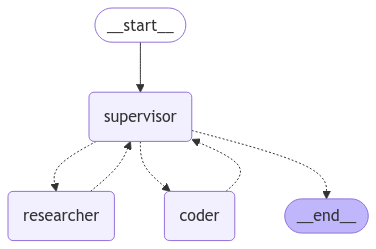

In [ ]:
research_agent = create_react_agent(
    llm, tools=[duckduckgo_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'coder'}})
----


Python REPL can execute arbitrary code. Use with caution.


(('coder:0ffe866b-9beb-c5c6-87a6-ef387edbcbb0',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8qed', 'function': {'arguments': '{"code": "import math\\nresult = math.sqrt(42)\\nprint(result)"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 221, 'total_tokens': 257, 'completion_time': 0.090652533, 'prompt_time': 0.013618148, 'queue_time': 0.23579281900000001, 'total_time': 0.104270681}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-64591a3a-90f1-4513-a450-7688b28c461e-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nresult = math.sqrt(42)\nprint(result)'}, 'id': 'call_8qed', 'type': 'tool_call'}], usage_metadata={'input_tokens': 221, 'output_tokens': 36, 'total_tokens': 257})]}})
----
(('coder:0ffe866b-9beb-c5c6-87a6-ef387edbcbb0',), {'tools': {'mess

In [17]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:93834039-177e-5ced-f402-8066ea5430fa',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ex8k', 'function': {'arguments': '{"query": "latest GDP of New York"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}, {'id': 'call_k4sm', 'function': {'arguments': '{"query": "latest GDP of California"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 204, 'total_tokens': 257, 'completion_time': 0.133612719, 'prompt_time': 0.01180638, 'queue_time': 0.236445157, 'total_time': 0.145419099}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c741d21c-79fb-478c-9b34-2d15dbd6f232-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'latest GDP of New York'}, 'id': 'call_ex8k', 'type': 'tool_call'}, {'name':

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool_call>\n{"name": "Router", "arguments": {"next": "researcher"}}'}}